\nAdvertising — Reconstruction Errors:\n  n_components  total_reconstruction_error  mse_per_entry
            1                1.377861e+05   2.296435e+02
            2                3.508688e+04   5.847813e+01
            3                4.759745e-25   7.932909e-28


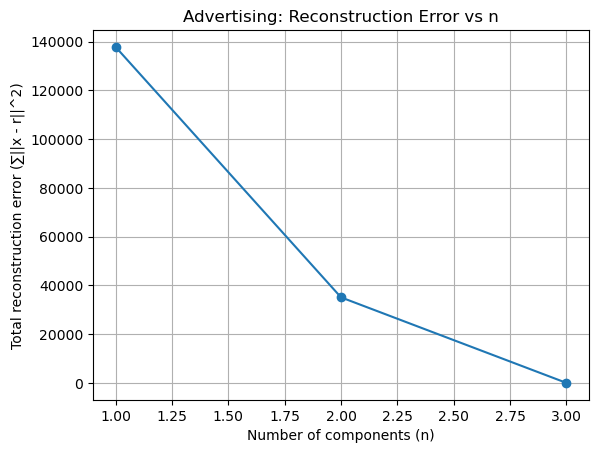

\nHousing — Reconstruction Errors:\n  n_components  total_reconstruction_error  mse_per_entry
            1                1.181699e+03   4.336509e-01
            2                6.540245e+02   2.400090e-01
            3                3.003325e+02   1.102138e-01
            5                5.480129e-23   2.011056e-26


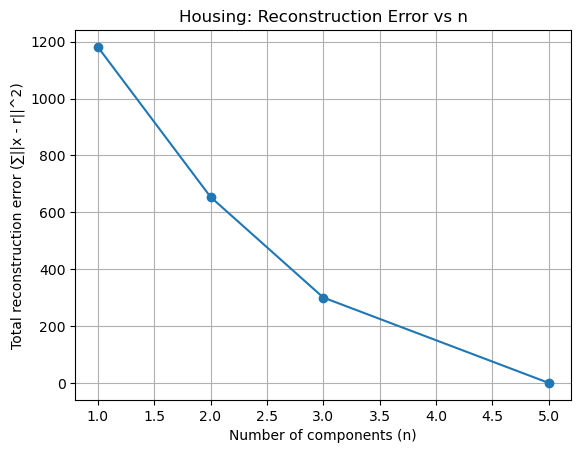

\nFAA_AI_Prelim — Reconstruction Errors:\n  n_components  total_reconstruction_error  mse_per_entry
            1                   27.783879       0.083686
            2                    3.320311       0.010001
            3                    1.320311       0.003977


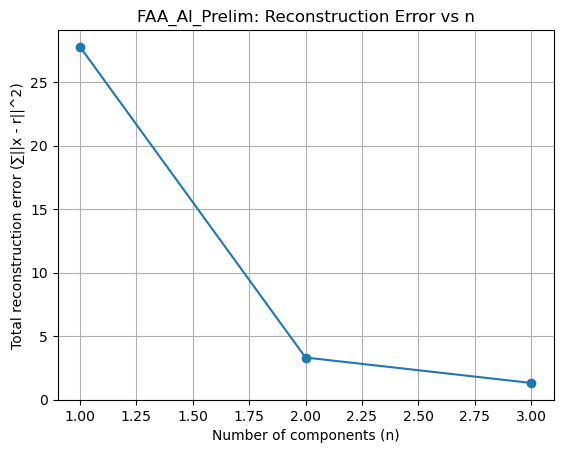

In [1]:
# PCA Reconstruction Error (Eigenfaces-style A^T A) for 3 Datasets
# - Loads advertising.csv, Housing.csv, faa_ai_prelim.csv from /mnt/data
# - Drops non-numeric columns and likely labels
# - Implements PCA via eigen-decomposition of A^T A
# - Reconstructs using top-n eigenvectors for n in [1,2,3,5,7,10,15]
# - Reports total reconstruction error (sum of squared errors)
# - Plots error vs n for each dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

paths = {
    "Advertising": r"C:\Users\LENOVO\Downloads\advertising.csv",
    "Housing": r"C:\Users\LENOVO\Downloads\Housing.csv",
    "FAA_AI_Prelim": r"C:\Users\LENOVO\Downloads\faa_ai_prelim.csv",
}

LIKELY_TARGET_NAMES = {
    "sales", "Sale", "Sales", "Target", "target", "TARGET",
    "price", "Price", "medv", "MEDV", "label", "Label", "class", "Class",
    "Outcome", "outcome", "y", "Y"
}

def prepare_numeric_matrix(df: pd.DataFrame):
    num_df = df.select_dtypes(include=[np.number]).copy()
    to_drop = [c for c in num_df.columns if c in LIKELY_TARGET_NAMES or c.lower() in {n.lower() for n in LIKELY_TARGET_NAMES}]
    num_df = num_df.drop(columns=to_drop, errors="ignore")
    for c in list(num_df.columns):
        s = num_df[c]
        if pd.api.types.is_integer_dtype(s) and s.is_monotonic_increasing and s.diff().dropna().isin([1]).all():
            num_df = num_df.drop(columns=[c])
        elif s.nunique(dropna=True) == len(s) and s.std(skipna=True) > 0 and s.isna().mean() < 0.2:
            num_df = num_df.drop(columns=[c])
    all_nan_cols = [c for c in num_df.columns if num_df[c].isna().all()]
    num_df = num_df.drop(columns=all_nan_cols)
    num_df = num_df.apply(lambda col: col.fillna(col.mean()), axis=0)
    zero_var_cols = [c for c in num_df.columns if np.isclose(num_df[c].var(ddof=0), 0.0)]
    num_df = num_df.drop(columns=zero_var_cols)
    return num_df

def pca_reconstruction_errors(X: pd.DataFrame, n_list):
    X_mat = X.values.astype(float)
    n_samples, n_features = X_mat.shape
    mu = X_mat.mean(axis=0, keepdims=True)
    A = X_mat - mu
    ATA = A.T @ A
    eigvals, eigvecs = np.linalg.eigh(ATA)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    results = []
    for k in sorted(set(n for n in n_list if n > 0 and n <= n_features)):
        E_k = eigvecs[:, :k]
        W = A @ E_k
        L = W @ E_k.T
        R = L + mu
        sse = float(np.sum((X_mat - R) ** 2))
        mse_per_entry = sse / (n_samples * n_features)
        results.append({"n_components": k, "total_reconstruction_error": sse, "mse_per_entry": mse_per_entry})
    return pd.DataFrame(results).sort_values("n_components").reset_index(drop=True)

dfs_raw = {name: pd.read_csv(p) for name, p in paths.items()}
n_grid = [1, 2, 3, 5, 7, 10, 15]
errors_tables = {}

for name, df in dfs_raw.items():
    X_df = prepare_numeric_matrix(df)
    n_list = [n for n in n_grid if n <= max(1, X_df.shape[1])]
    if len(n_list) == 0:
        errors_tables[name] = pd.DataFrame(columns=["n_components", "total_reconstruction_error", "mse_per_entry"])
    else:
        errors_tables[name] = pca_reconstruction_errors(X_df, n_list)

for name, tbl in errors_tables.items():
    if tbl.empty:
        continue
    print(f"\\n{name} — Reconstruction Errors:\\n", tbl.to_string(index=False))
    plt.figure()
    plt.plot(tbl["n_components"], tbl["total_reconstruction_error"], marker="o")
    plt.xlabel("Number of components (n)")
    plt.ylabel("Total reconstruction error (∑||x - r||^2)")
    plt.title(f"{name}: Reconstruction Error vs n")
    plt.grid(True)
    plt.show()


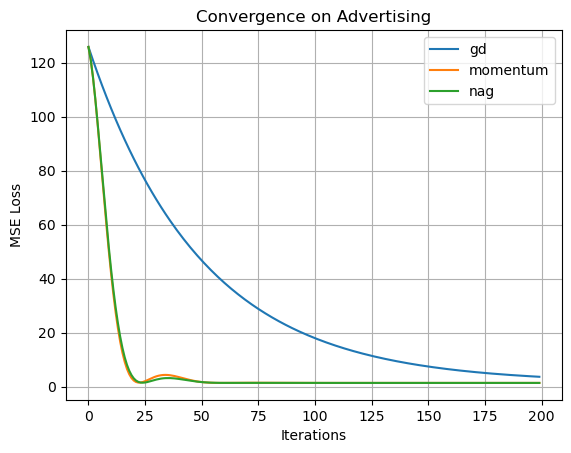

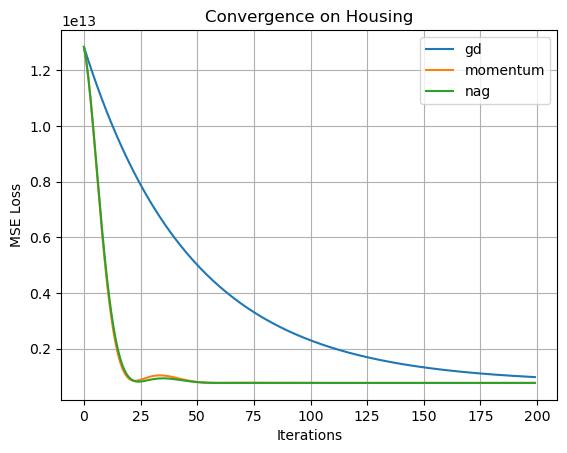

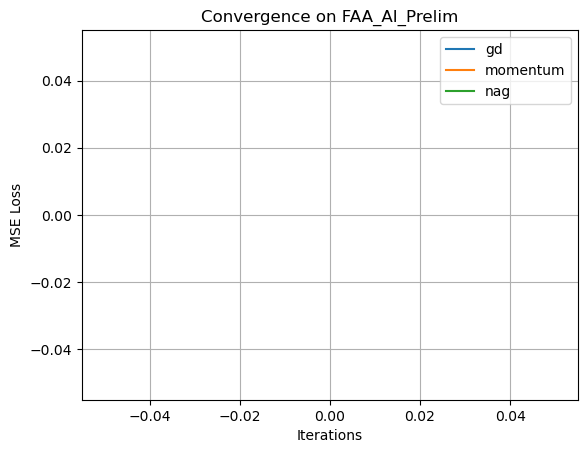

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) Load datasets
# -----------------------------
paths = {
    "Advertising": r"C:\Users\LENOVO\Downloads\advertising.csv",
    "Housing": r"C:\Users\LENOVO\Downloads\Housing.csv",
    "FAA_AI_Prelim": r"C:\Users\LENOVO\Downloads\faa_ai_prelim.csv",
}
dfs_raw = {name: pd.read_csv(p) for name, p in paths.items()}

# -----------------------------
# 2) Guess target column
# -----------------------------
TARGETS = {
    "Advertising": "Sales",   # known target
    "Housing": "price",       # likely target
    "FAA_AI_Prelim": None     # fallback = last numeric
}

def pick_target(df, default=None):
    if default and default in df.columns:
        return default
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return num_cols[-1] if num_cols else None

targets = {name: pick_target(df, TARGETS.get(name)) for name, df in dfs_raw.items()}

# -----------------------------
# 3) Prepare X, y (clean + standardize)
# -----------------------------
prepared = {}
for name, df in dfs_raw.items():
    tcol = targets[name]
    if tcol is None or tcol not in df.columns:
        continue

    # Target variable
    y = df[tcol].values.astype(float).reshape(-1, 1)

    # Feature matrix (numeric only)
    X = df.drop(columns=[tcol]).select_dtypes(include=[np.number])

    # Fill missing values with column mean
    X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

    # Drop zero variance columns
    zero_var_cols = [c for c in X.columns if X[c].nunique() <= 1]
    X = X.drop(columns=zero_var_cols, errors="ignore")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    # Add bias column (intercept term)
    X_aug = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

    prepared[name] = (X_aug, y)

# -----------------------------
# 4) Loss and gradient functions
# -----------------------------
def mse_loss(X, y, w):
    m = len(y)
    preds = X @ w
    return (1/(2*m)) * np.sum((preds - y)**2)

def grad(X, y, w):
    m = len(y)
    return (1/m) * X.T @ (X @ w - y)

# -----------------------------
# 5) Gradient Descent Variants
# -----------------------------
def gradient_descent(X, y, lr=0.01, max_iter=200, method="gd", gamma=0.9):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1))
    v = np.zeros_like(w)
    history = []
    for t in range(max_iter):
        if method == "gd":
            g = grad(X, y, w)
            w = w - lr * g
        elif method == "momentum":
            g = grad(X, y, w)
            v = gamma * v + lr * g
            w = w - v
        elif method == "nag":
            g = grad(X, y, w - gamma * v)
            v = gamma * v + lr * g
            w = w - v
        history.append(mse_loss(X, y, w))
    return w, history

# -----------------------------
# 6) Run experiments
# -----------------------------
results = {}
for name, (X, y) in prepared.items():
    results[name] = {}
    for method in ["gd", "momentum", "nag"]:
        _, hist = gradient_descent(X, y, lr=0.01, max_iter=200, method=method)
        results[name][method] = hist

# -----------------------------
# 7) Plot convergence
# -----------------------------
for name, methods in results.items():
   # plt.figure(figsize=(20,20))
    for method, hist in methods.items():
        plt.plot(hist, label=method)
    plt.xlabel("Iterations")
    plt.ylabel("MSE Loss")
    plt.title(f"Convergence on {name}")
    plt.legend()
    plt.grid(True)
    plt.show()
